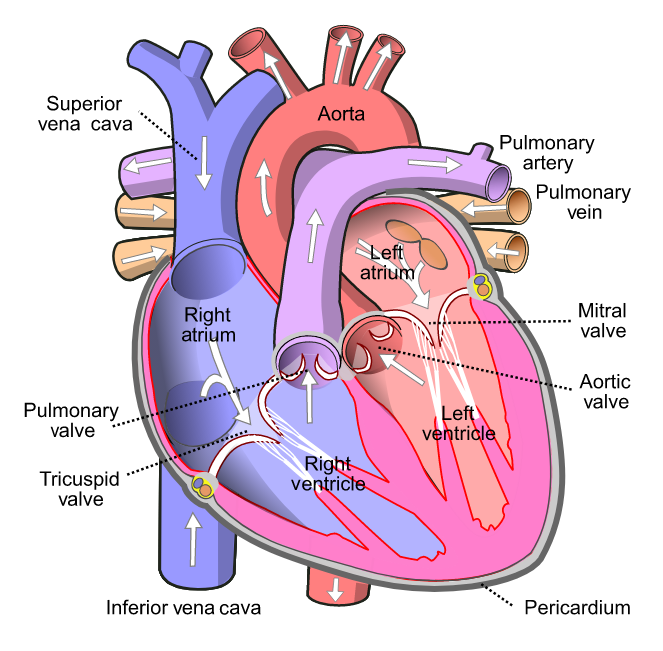

First a bit about the dataset itself. The dataset contains 303 samples of various attributes that could be suggestive of a heart disease. The goal is to find patterns in the dataset and predict whether or not the sample is suggestive of a heart disease. I found this dataset particularly interesting because of a few reasons. First the sample size and attributes per sample is not very satisfactory. Out of 303 if we set aside for validation and test then we got about 170 samples to train upon. Second, there are attributes like "sex", "fbs", "exang" that are binary and there are attributes that can take any integral value within a range. I feel it would be interesting to see how these attributes cast their vote on the final target decision. Last but pehaps the most important, I am personally inclined to learn ML and find opportunities to solve some of the challenging areas in Human medicine.

### Load the dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./heart.csv")

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
target_name = 'target'
y = data[target_name]
X = data.drop([target_name], axis=1)

In [5]:
#Encoding categorical data values
from sklearn.preprocessing import LabelEncoder
labelencoder_Y = LabelEncoder()
y = labelencoder_Y.fit_transform(y)

In [6]:
from sklearn.preprocessing import StandardScaler
## split into cross-validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

X_train_cross, X_test_cross, y_train_cross, y_test_cross = \
    train_test_split(X_train, y_train, random_state=0)

print("y shape", y.shape)
print("y_train_cross shape", y_train_cross.shape)
print("y_test_cross shape", y_test_cross.shape)
np.random.seed(0)

y shape (303,)
y_train_cross shape (170,)
y_test_cross shape (57,)


### Decision Tree Classifier

#### Model accuracy as func of tree depth

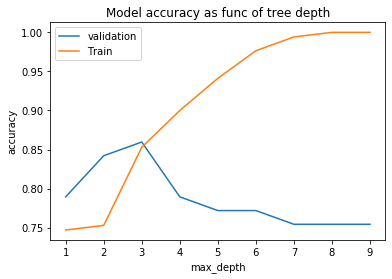

CPU times: user 274 ms, sys: 11.2 ms, total: 286 ms
Wall time: 283 ms


In [8]:
%%time
# training/test performance by controlling as a function of tree depth.
accuracy_val = []
accuracy_train = []

rLow = 1
rHigh = 10
rStep = 1
for i in range(rLow, rHigh, rStep):
#     print(y_train_cross.shape, y_test_cross.shape)

    clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=i)
    clf.fit(X_train_cross, y_train_cross)
    score = clf.score(X_test_cross, y_test_cross)
    accuracy_val.append(score)
    
    score = clf.score(X_train_cross, y_train_cross)
    accuracy_train.append(score)

x = list(range(rLow, rHigh, rStep))
plt.plot(x, accuracy_val, label="validation")
plt.plot(x, accuracy_train, label="Train")

plt.xticks(x)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Model accuracy as func of tree depth")
plt.legend()

plt.show()

We observe steady increase in model's training and validation accuracies when the tree depth is low. After a certain point(depth=3) the model seems like over-fitting the training data. This is expected as incresing the depth means increasing the number of decision nodes. Each added decision node learns a bit more from the training data untill a point where it starts learning the noises as well. The train accuracies continue to improve as the model learns almost eveything from the data but loses generalization. We could see as depth is increased to 9, the model has memorized all the training data including the noises as the training performance reaches 1.0 but the validation performance falls to less than 0.75.

Depth=3 seems to be the golden point where the train and validation accuracies are optimum.
The model took about 200ms for 9 iterations, averaging to 22ms

#### model learning curve

Test score 0.7763157894736842


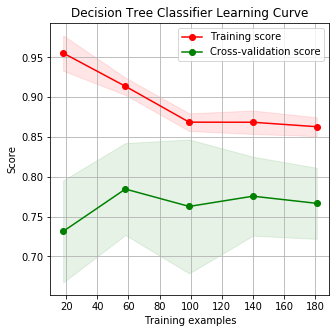

In [9]:
from plot_learning_curve import plot_learning_curve
from plot_learning_curve import plot_fit_time

DTree = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=3)
plot_learning_curve(DTree, "Decision Tree Classifier Learning Curve", X_train, y_train)

# clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=5)
# DTree.fit(X_train_cross, y_train_cross)
# score = DTree.score(X_test_cross, y_test_cross)
# print("validation score", score)

DTree.fit(X_train_cross, y_train_cross)
score = DTree.score(X_test, y_test)
print("Test score", score)

Test score 0.7763157894736842

The above plot shows the learning curve of a Decision Tree classifier. A couple of things to note here. First, we controlled on the over-fitting by introducing pruning. With tree depth restricted to 3, we are seeing train accuracy is not approaching 1.0 and both train and validation accuracy are moving towards convergence.

We can observe from above that the training accuracy reduces and CV accuracy increases as we add more examples in the training pool. This is expected because with very low number of samples there isn't any learning that can be picked up, reflected by low CV score. As more samples are added keeping the tree depth fixed we see the model offsetting the effect of initial over-fitting and gradually converging.

We can observe that the test score matches that of CV score but there is still a big delta with the training score. The model seems to be not able to generalize well over the CV data. Appying other methods of post-prunning like ccp_alpha might help to some extent.

#### Model performance on split ratio

(204,) (23,)
9
(192,) (35,)
9
(181,) (46,)
9
(170,) (57,)
8
(158,) (69,)
8


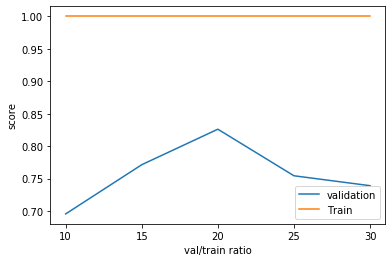

CPU times: user 272 ms, sys: 20.9 ms, total: 293 ms
Wall time: 281 ms


In [10]:
%%time
# model performance playing with train/cross ratio.

accuracy_val = []
accuracy_train = []

rLow = 10
rHigh = 35
rStep = 5

for i in range(rLow, rHigh, rStep):
    X_train_cross, X_test_cross, y_train_cross, y_test_cross = \
        train_test_split(X_train, y_train, test_size = i*0.01, random_state=0)
    print(y_train_cross.shape, y_test_cross.shape)

    clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0)
    clf.fit(X_train_cross, y_train_cross)
    depth = clf.tree_.max_depth
    print(depth)
    score = clf.score(X_test_cross, y_test_cross)
    accuracy_val.append(score)
    
    score = clf.score(X_train_cross, y_train_cross)
    accuracy_train.append(score)


x = list(range(rLow, rHigh, rStep))
plt.plot(x, accuracy_val, label="validation")
plt.plot(x, accuracy_train, label="Train")

plt.xticks(x)
plt.xlabel('val/train ratio')
plt.ylabel('score')
plt.legend()

plt.show()

At 10% split there are 204 training samples which are perfectly consumed by growing the tree to depth 9, as we see train accuracy reaches 1.0. However because of over-fitting at depth=9 validation score is very low.
At 20% there are 181 training samples which are again consumed completely as accuracy reaches 1.0. Reducing the training samples to 181 offsets the effect of over-fiiting and we see model is able to generalize more as it has seen less training data compared to 10% split. This is reflected by validation accuracy reaching to ~0.85.
Past 20% split there is not enough data to train the model adequately. The tree depth reduces to 8 as it does not need to expand more to learn the training data. Obvioulsy the model manages to memorize all the trainig data but that is just not enough to explain the validation data and that is reflected by drop in validation accuracy.

#### Model fitting time relation with number of train samples

<module 'matplotlib.pyplot' from '/Users/Rudrajit/miniconda3/envs/ai_env/lib/python3.7/site-packages/matplotlib/pyplot.py'>

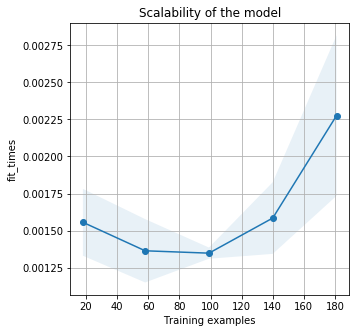

In [11]:
DTree = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=3)
plot_fit_time(DTree, "Decision Tree Classifier Fitting time Curve", X_train, y_train)

The plot show the time required by the model to train with various sizes of training dataset. We can observe that the fit time increases as new samples are added, which is expected with Decision Trees as there is no parallelization. Decision trees are quite fast. To train on 180 samples it took about 17ms. In the above experiment we used max_depth as the pruning method and restricted the tree expansion to level 3. Restricting the tree depth to a max_depth helps by not making the extra decision nodes that would otherwise exist to fit the train data to best extent.

#### model performance as function of max_features

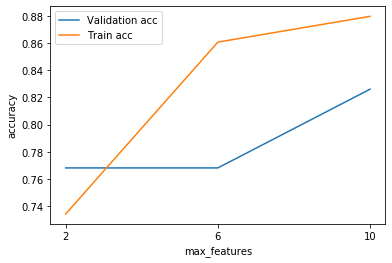

In [12]:
accuracy_train = []
accuracy_val = []
rLow = 2
rHigh = 14
rStep = 4

for i in range(rLow, rHigh, rStep):
    clf = None
    clf = DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_features=i, max_depth=4)
    clf.fit(X_train_cross, y_train_cross)

    score = clf.score(X_train_cross, y_train_cross)
    accuracy_train.append(score)
    
    score = clf.score(X_test_cross, y_test_cross)
    accuracy_val.append(score)

x = list(range(rLow, rHigh, rStep))
plt.plot(x, accuracy_val, label="Validation acc")
plt.plot(x, accuracy_train, label="Train acc")

plt.xticks(x)
plt.xlabel('max_features')
plt.ylabel('accuracy')
plt.legend()

plt.show()

We would expect both train and validation accuracy to increase as number of features are increased. This is because every added feature would offer one more "control" for the decision nodes. In other words, it would help to categorize a sample in 4 categories if it had 2 features rather than just 1 feature.
Though we see linear improvement in training accuracy for max_feature<6, there isn't any improvement in testing accuracy. That is probably because the model didnot acquire any significant generalized learning when features are too low.

A couple of things to note here. First, we controlled on the over-fitting by introducing pruning. With tree depth restricted to 3, we are seeing train accuracy is not approaching 1.0 and both train and validation accuracy match. Second, the model seems to be showing high bias and high variance. We can say it has high bias because both train/validation accuracy is low and it has high variance because test score is much lower than the train/validation score. 
##### Add comments

# kNN Classifier

In [13]:
from sklearn.neighbors import KNeighborsClassifier

#### Model complexity and impact on performance

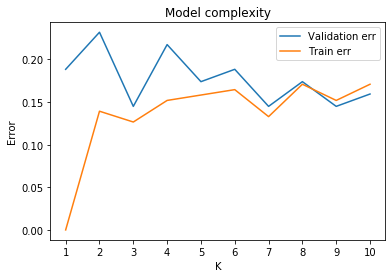

CPU times: user 531 ms, sys: 12.8 ms, total: 544 ms
Wall time: 540 ms


In [14]:
%%time
# training/test performance as a funct of K.
err_val = []
err_train = []

rLow = 1
rHigh = 11
rStep = 1
for i in range(rLow, rHigh, rStep):
    clf = None
    clf = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2, weights='uniform')
    clf.fit(X_train_cross, y_train_cross)
    
    score = clf.score(X_train_cross, y_train_cross)
    err_train.append(1-score)
    
    score = clf.score(X_test_cross, y_test_cross)
    err_val.append(1-score)

# print(accuracy_train)
# print(accuracy_val)

x = list(range(rLow, rHigh, rStep))
plt.plot(x, err_val, label="Validation err")
plt.plot(x, err_train, label="Train err")

plt.xticks(x)
plt.xlabel('K')
plt.ylabel('Error')
plt.title("Model complexity")
plt.legend()

plt.show()

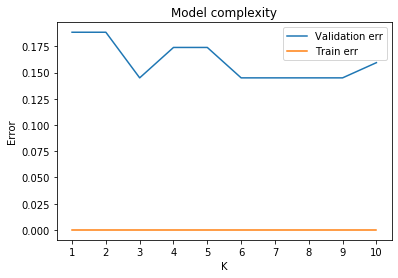

CPU times: user 331 ms, sys: 8.58 ms, total: 339 ms
Wall time: 338 ms


In [15]:
%%time
# training/test performance as a funct of K.
err_val = []
err_train = []

rLow = 1
rHigh = 11
rStep = 1
for i in range(rLow, rHigh, rStep):
    clf = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2, weights='distance')
    clf.fit(X_train_cross, y_train_cross)
    
    score = clf.score(X_train_cross, y_train_cross)
    err_train.append(1-score)
    
    score = clf.score(X_test_cross, y_test_cross)
    err_val.append(1-score)

# print(accuracy_train)
# print(accuracy_val)

x = list(range(rLow, rHigh, rStep))
plt.plot(x, err_val, label="Validation err")
plt.plot(x, err_train, label="Train err")

plt.xticks(x)
plt.xlabel('K')
plt.ylabel('Error')
plt.title("Model complexity")
plt.legend()

plt.show()

First thing noticeable is that kNN is more time consuming than Decision Trees.
We observe that when K=1 training error=0. This is expected because at K=1 the decision is just based on the data point itself. It is also clear that with K=1 the model is highly specialized to the data points in the training, which also means it won't generalize well over the validation set and that is reflected by low validation score (High Bias).

As the model complexity reduces by increasing the K the decision boundary starts smoothing that in turn offsets the effect of specialization on training data. This is correctly reflected in the graph above as we observe training error increases and validation error reduces.

One thing to note in the above graph is kNN is configured to "see" all K neighbors as uniform and that is the reason train accuracy falls when averaging many neighbors. If the neighbors votes are weighted according to their distance from the data point then the data point itself would have majority stake in the output decision and we would see train error close to 0 as shown in the below graph.

From above we can establish that k=5 is optimal on train/validation set. From the error rates we can already see that the model has very low variance when the MC factor k=5. We can also notice that reducing the model complexity (k>=5) will shift the model to High Bias region, where as reducing the complexity (k<5) would drag the model into High Variance region.

#### kNN Learning curve

Test score 0.8421052631578947


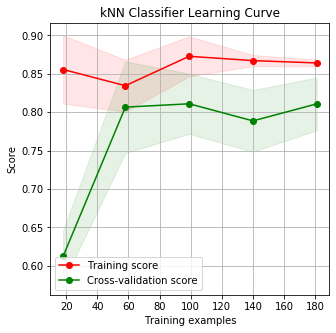

In [16]:
from plot_learning_curve import plot_learning_curve
from plot_learning_curve import plot_fit_time

kNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2, weights='uniform')
plot_learning_curve(kNN, "kNN Classifier Learning Curve", X_train, y_train)

kNN.fit(X_train_cross, y_train_cross)
score = kNN.score(X_test, y_test)
print("Test score", score)

We observe the Test score 0.8421052631578947.
The above plot shows the learning curve of the kNN model. Since k is  equal to 5, all the 5 neighbors around the data point votes for the decision equally and that is the reason why we don't see train accuracy 1.0 even for low number of samples. However we still see the model over-fitting when the sample size is too low. As we increase the number of data points the CV score increases as it learns features from the new data. 

At model complexity k=5 we see the kNN performs optimally on this data set. We established earlier from model complexity analysis that k=5 is optimal on train/validation set. From the error rates we can already see that the model has low variance when the model complexity factor k=5.

We can also notice that reducing the model complexity (k>=5) will shift the model to High Bias region, where as reducing the complexity (k<5) would drag the model into High Variance region.

#### Model performance on split ratio

(192,) (35,)
(181,) (46,)
(170,) (57,)
(158,) (69,)
(147,) (80,)
(136,) (91,)
(124,) (103,)


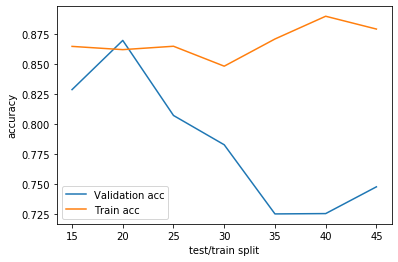

CPU times: user 453 ms, sys: 13.4 ms, total: 467 ms
Wall time: 486 ms


In [17]:
%%time
# model performance playing with train/cross ratio.

accuracy_val = []
accuracy_train = []

rLow = 15
rHigh = 50
rStep = 5
for i in range(rLow, rHigh, rStep):
    X_train_cross, X_test_cross, y_train_cross, y_test_cross = \
        train_test_split(X_train, y_train, test_size = i*0.01, random_state=0)
    print(y_train_cross.shape, y_test_cross.shape)

    clf = KNeighborsClassifier(n_neighbors = 4,  metric = 'minkowski', p = 2)
    clf.fit(X_train_cross, y_train_cross)
    score = clf.score(X_test_cross, y_test_cross)
    accuracy_val.append(score)
    
    score = clf.score(X_train_cross, y_train_cross)
    accuracy_train.append(score)

x = list(range(rLow, rHigh, rStep))
plt.plot(x, accuracy_val, label="Validation acc")
plt.plot(x, accuracy_train, label="Train acc")

plt.xticks(x)
plt.xlabel('test/train split')
plt.ylabel('accuracy')
plt.legend()

plt.show()

We observe the test accuracy constantly falls in most part of the graph. This is true because as the split ratio increases the data samples available for training reduces and it is not enough to pickup significant learning from the data. At K=4 training accuracy is flat at 0.85 which is what we saw in the model complexity graph earlier. As the train data is reduced further the model starts grossly over-fitting which is explained by steep increase in train curve where as steep fall in test curve due to lack of generalization.

#### Model fitting time relation with number of train samples

<module 'matplotlib.pyplot' from '/Users/Rudrajit/miniconda3/envs/ai_env/lib/python3.7/site-packages/matplotlib/pyplot.py'>

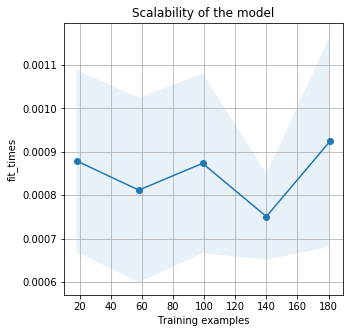

In [21]:
np.random.seed(0)
kNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2, weights='uniform')
plot_fit_time(kNN, "kNN Classifier Fitting Time Curve", X_train, y_train)

The above plot shows fitting time as a function of traing examples. It is expected that as number of examples increase the fitting time would increase because every new sample has to go through the decision process and they are not parallelized.

# Boosting

In [22]:
from sklearn.ensemble import AdaBoostClassifier

In [23]:
## split into cross-validation set
X_train_cross, X_test_cross, y_train_cross, y_test_cross = \
    train_test_split(X_train, y_train, random_state=0)

#### Model error as a function of number of weak classifiers ensemble.

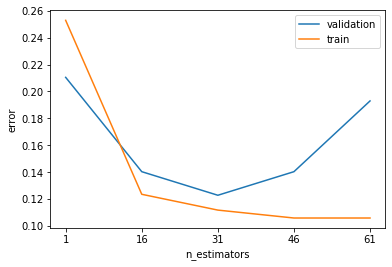

In [24]:
# Lets first see what is the accuracy without the Adaboost.
# Effect of n_estimators
acc_val = []
acc_train = []
rLow = 1
rHigh = 70
rStep = 15
for i in range(rLow, rHigh, rStep):
    clf = None
    clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=1),
                              n_estimators=i, random_state=0, learning_rate=0.4)
    clf.fit(X_train_cross, y_train_cross)

    score = clf.score(X_train_cross, y_train_cross)
    acc_train.append(1-score)

    score = clf.score(X_test_cross, y_test_cross)
    acc_val.append(1-score)

x = list(range(rLow, rHigh, rStep))
plt.plot(x, acc_val, label="validation")
plt.plot(x, acc_train, label="train")

plt.xticks(x)
plt.xlabel('n_estimators')
plt.ylabel('error')
plt.legend()

plt.show()

The above shows a plot of the model error as we change the number of weak classifiers(n_estimators) in the Adaptive Boost algorithm. 
High Bias - When n_estimators=1 we see both training and validation errors are large suggestive of high bias region. This is expected as with n_estimators=1 its just a weak classifier with very low tree depth(max_depth=1). This is the region of under-fitting where the model is not learning enough from the data.

As n_estimators are increased train and validation errors continue to fall. This is expected because at n_estimators=31 we have trained the model enough times on the failing data points to learn the features from the training data. 

High Variance - As the n_estimators increase even more, we see the model almost memorized all the training data and the same is reflected in the training error rate that falls to almost 0. However, as expected the model loses the flexibility to generalize on the validation data and that is reflected by steep increase in the validation error rate.

The point in between High Bias and High Variance is what we should be tuning the model to. Looking at the plot, n_estimators=31 seems to be the optimal point where the validation and training error are both low.

#### Effect of learning rate on AdaBoost

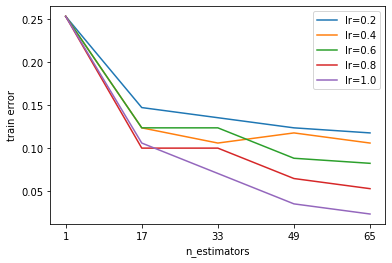

In [25]:
# Lets first see what is the accuracy without the Adaboost.
# Effect of n_estimators
acc_val = []
acc_train = []
rLow = 1
rHigh = 70
rStep = 16
lr = [0.2, 0.4, 0.6, 0.8, 1.0]

for index in range(len(lr)):
    acc_train.append([])
    for i in range(rLow, rHigh, rStep):
        clf = None
        clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=0, max_depth=1),
                                  n_estimators=i, random_state=0, learning_rate=lr[index])
        clf.fit(X_train_cross, y_train_cross)

        score = clf.score(X_train_cross, y_train_cross)
        acc_train[index].append(1-score)

x = list(range(rLow, rHigh, rStep))
for index in range(len(lr)):
    plt.plot(x, acc_train[index], label="lr="+str(lr[index]))

plt.xticks(x)
plt.xlabel('n_estimators')
plt.ylabel('train error')
plt.legend()

plt.show()

Now we observe the effect of learning rate on training error over a range of n_estimators. We notice that learning rate controls the slope of the curve. For e.g. at n_estimators=17, the error drops sharply for lr=1.0 as compared to lr=0.2(drops gently). Similarly we can see that for n_estimators = 65, the error drop is steep for lr=1.0 than lr=0.2.
This is expected because there is a tradeoff between n_estimators and how much we are going to contribute with the new model to the existing one(learning rate). When lr is less the contribution is less and therefore it takes more n_estimators for same drop in error as compared to higher learning rate.          

#### Adaptive Boosting Learning Curve n_estimators=10

Test score 0.8157894736842105


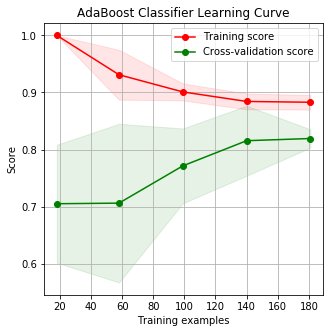

In [32]:
from plot_learning_curve import plot_learning_curve
from plot_learning_curve import plot_fit_time

ada = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=1)
                         ,n_estimators=10,random_state=0)
plot_learning_curve(ada, "AdaBoost Classifier Learning Curve", X_train, y_train)

ada.fit(X_train_cross, y_train_cross)
score = ada.score(X_test, y_test)
print("Test score", score)

#### Adaptive Boosting Learning Curve n_estimators=31

Test score 0.8289473684210527


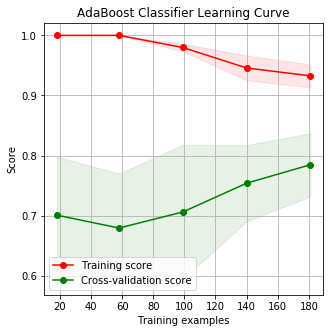

In [36]:
from plot_learning_curve import plot_learning_curve
from plot_learning_curve import plot_fit_time

ada = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=1)
                         ,n_estimators=31,random_state=0)
plot_learning_curve(ada, "AdaBoost Classifier Learning Curve", X_train, y_train)

ada.fit(X_train_cross, y_train_cross)
score = ada.score(X_test, y_test)
print("Test score", score)

The above two plots shows the learning curves for n_estimators = 10 and n_estimators = 31. First thing we would notice comparing the learning curves is that the variance is increasing as n_estimators increases. We have already analyzed from the model complexity that the model shifts from high bias to high variance as n_estimators increases. It can also be noticed that for low sample size the model is over-fitting as we can obseve the training score 1.0 whereas the CV score is very low. As we add more data points keeping the n_estimators fixed the model gradually learns to generalize on the data set and that is reflected by the CV score improvement.

Another interesting thing to note is when we compare the training scores for n_estimators=10 vs n_estimators=31 especially when the sample size is less than 40, we see the chances of overfitting are more when n_estimators increases for the same sample size and same tree depth of weak classifiers. I would think this is happening because the when n_estimators grows we are doing more iterations feeding in the failed samples and eventually the model masters them and memorizes thereby giving perfect score on train data, though it loses generalization in the process.

#### Model fitting time relation with number of train samples

<module 'matplotlib.pyplot' from '/Users/Rudrajit/miniconda3/envs/ai_env/lib/python3.7/site-packages/matplotlib/pyplot.py'>

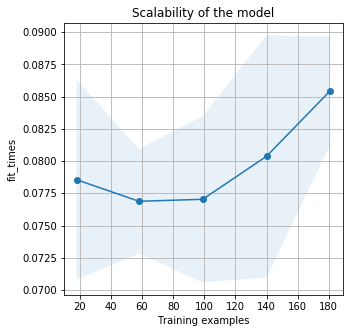

In [38]:
np.random.seed(0)
ada = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'entropy', random_state=0, max_depth=1)
                         ,n_estimators=31,random_state=0)
plot_fit_time(ada, "AdaBoost Classifier Fitting Time Curve", X_train, y_train)

It can be easily seen that Adaboost is more exhaustive than DecisionTree itself as it is an ensemble of n_estimators together. Also we see it is more exhaustive than kNN classifier. The above plot is for n_estimators=31. We would expect these numbers to go higher as n_estimators increases.

# Neural Network Classifier

In [45]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras import backend as K
import numpy as np

#### Effect of epochs on train/validation data

In [46]:
## split into cross-validation set
X_train_cross, X_test_cross, y_train_cross, y_test_cross = \
    train_test_split(X_train, y_train, random_state=0)

In [47]:
# model architecture
K.clear_session()
np.random.seed(0)
classifier = Sequential() 
classifier.add(Dense(units = 24, activation = 'relu', input_dim = X_train.shape[1], kernel_initializer='random_normal'))
classifier.add(Dropout(0.2))

classifier.add(Dense(units = 12, activation = 'relu', kernel_initializer='random_normal'))
classifier.add(Dropout(0.2))

classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='random_normal'))
classifier.compile(optimizer = RMSprop(), loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                336       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 649
Trainable params: 649
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = classifier.fit(X_train_cross, y_train_cross, validation_data = 
                         (X_test_cross,y_test_cross), epochs=300, batch_size=64, shuffle=False, verbose=0)
print(K.eval(classifier.optimizer.lr))

0.001


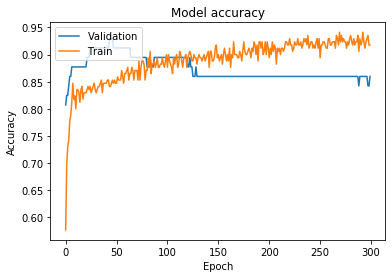

In [49]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

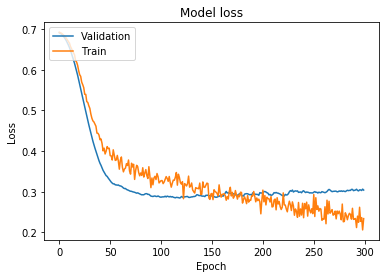

In [50]:
plt.plot(history.history['val_loss']) 
plt.plot(history.history['loss'])

plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Validation', 'Train'], loc='upper left') 
plt.show()

We can observe from the train/validation curve that the losses continue to fall as the epochs are increasing. This is expected because with each epoch the network is learning patterns from the training data so the losses would decreaase. Up untill 150 epochs the validation and train losses continue to decrease but as epochs increases even more we see the network picking up the noise in the training data as well. As an effect of that the training loss continue to fall but the validation loss starts increasing. We can clearly see the network is over-fitting at epochs beyond 150.

#### Effect of learning rate on model accuracy

In [61]:
## split into cross-validation set
X_train_cross, X_test_cross, y_train_cross, y_test_cross = \
    train_test_split(X_train, y_train, random_state=0)

In [62]:
# model architecture
def create_model(lr):
    K.clear_session()
    np.random.seed(0)
    classifier = Sequential() 
    classifier.add(Dense(units = 24, activation = 'relu', input_dim = X_train.shape[1], kernel_initializer='random_normal'))
    classifier.add(Dropout(0.2))

    classifier.add(Dense(units = 12, activation = 'relu', kernel_initializer='random_normal'))
    classifier.add(Dropout(0.2))

    classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='random_normal'))
    classifier.compile(optimizer = RMSprop(lr=lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
#     classifier.summary()
    return classifier

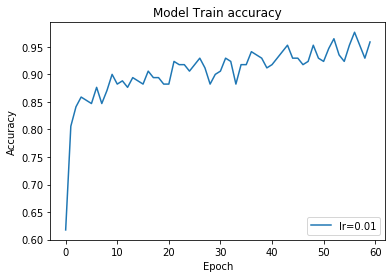

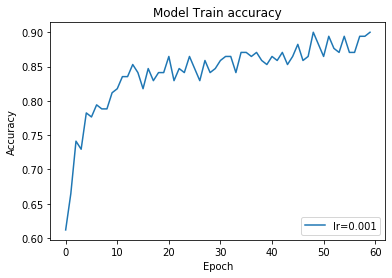

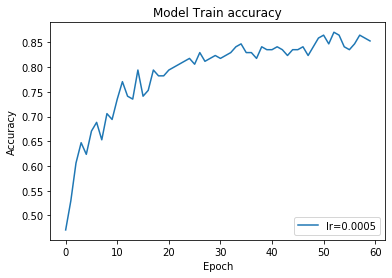

In [63]:
lr = [1E-2, 1E-3, 5E-4]

for index in range(len(lr)):
    clf = None
    clf = create_model(lr[index])

    history = clf.fit(X_train_cross, y_train_cross, validation_data = 
                     (X_test_cross,y_test_cross), epochs=60, shuffle=False, verbose=0)
    plt.plot(history.history['accuracy'])

    plt.title('Model Train accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['lr='+str(lr[index])], loc='lower right')
    plt.show()

As we can see from the above plots learning rate effects the number of epochs consumed to reach a certain accuracy. It is infact the factor by which the model allows change in the weights and in turn effect the amount of learning from epoch to epoch. For e.g. when the lr=1E-2 it took less than 5 epochs to reach accuracy 0.85, whereas it took about 30 epochs to reach same accuracy when lr=1E-3 and about 50 epochs when the lr=5E-4.

#### Model performance on test set

In [54]:
## split into cross-validation set
X_train_cross, X_test_cross, y_train_cross, y_test_cross = \
    train_test_split(X_train, y_train, random_state=0)

In [55]:
# model architecture
K.clear_session()
np.random.seed(0)
classifier = Sequential() 
classifier.add(Dense(units = 24, activation = 'relu', input_dim = X_train.shape[1], kernel_initializer='random_normal'))
classifier.add(Dropout(0.2))

classifier.add(Dense(units = 12, activation = 'relu', kernel_initializer='random_normal'))
classifier.add(Dropout(0.2))

classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='random_normal'))
classifier.compile(optimizer = RMSprop(), loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                336       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 649
Trainable params: 649
Non-trainable params: 0
_________________________________________________________________


In [56]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
history = classifier.fit(X_train_cross, y_train_cross, validation_data = 
                         (X_test_cross,y_test_cross), epochs=300, callbacks=[callback], shuffle=False, verbose=0)
scores = clf.evaluate(X_train_cross, y_train_cross, verbose=0)
print("Train %s: %.2f%%" % (classifier.metrics_names[1], scores[1]*100))

scores = classifier.evaluate(X_test_cross, y_test_cross, verbose=0)
print("Validation %s: %.2f%%" % (classifier.metrics_names[1], scores[1]*100))

scores = classifier.evaluate(X_test, y_test, verbose=0)
print("Test %s: %.2f%%" % (classifier.metrics_names[1], scores[1]*100))

Train accuracy: 85.88%
Validation accuracy: 89.47%
Test accuracy: 86.84%


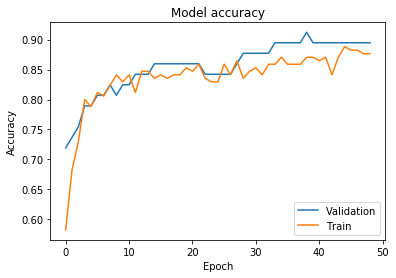

In [57]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation','Train'], loc='lower right')
plt.show()

Train accuracy: 84.12%
Validation accuracy: 89.47%
Test accuracy: 84.21%

As we can see from the above plot train/validation performance increases upto 50 epochs after which the model does not show any further reduction in loss and cuts off the training early. Though the training and test accuracy are close match the validation accuracy seems to be off from training accuracy. Perhaps we could do K-folds on the training data and average out the results to get a better estimate.

# Support Vector Machines

In [64]:
from sklearn.svm import SVC

In [65]:
## split into cross-validation set
X_train_cross, X_test_cross, y_train_cross, y_test_cross = \
    train_test_split(X_train, y_train, random_state=0)

Test score 0.8552631578947368


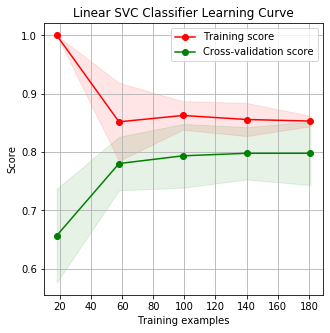

In [66]:
from plot_learning_curve import plot_learning_curve
from plot_learning_curve import plot_fit_time

svcLin = SVC(kernel = 'linear', random_state = 0, verbose=False)
plot_learning_curve(svcLin, "Linear SVC Classifier Learning Curve", X_train, y_train)

svcLin.fit(X_train_cross, y_train_cross)
score = svcLin.score(X_test, y_test)
print("Test score", score)

Test score 0.8947368421052632


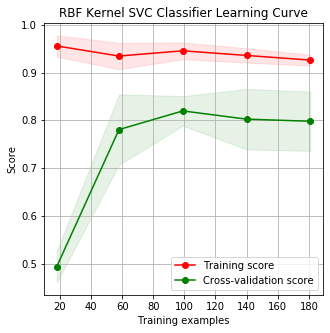

In [67]:
from plot_learning_curve import plot_learning_curve
from plot_learning_curve import plot_fit_time

svcRbf = SVC(kernel = 'rbf', random_state = 0, verbose=False)
plot_learning_curve(svcRbf, "RBF Kernel SVC Classifier Learning Curve", X_train, y_train)

svcRbf.fit(X_train_cross, y_train_cross)
score = svcRbf.score(X_test, y_test)
print("Test score", score)